In [1]:
#near duplicate detection and elimination
#next steps - obtain more data
#near entity recognition - spacy
#relabeling

# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [29]:
data_path = '../data/training_test_data/'
data = pd.read_csv(data_path + 'after_stock_data_cleaned.csv')
colnames = ['headline','source','label']   
data.columns = colnames

data2 = pd.read_csv(data_path + 'now_data_parsed.csv')

data2.columns = ['headline','label']

data2_labeled = pd.concat([data2[438:2438], data2[6448:8448],data2[12458:14458],data2[18468:20709]])

data2_labeled.head()

,headline,label
438,amazon opens preorders for cinderella annivers...,1
439,google researchers add attention to augment co...,1
440,android q the choice of the final name for goo...,1
441,google to phase out works with nestprogram in ...,1
442,google announces major android auto update wit...,1


In [30]:
#dataset specific cleansing and concatenation, not bothering source cleanup since we don't have source for new data

#for i, row in data[data['source'].str.find(' via ') > -1].iterrows():
#  data.at[i,'source'] = data.at[i,'source'][:data.at[i,'source'].find(' via ')].strip()

#data.head()
#data2.head()

In [31]:
#this was to split source out of initial labeled data

#sources = []
#headlines = []

#for i, row in data2.iterrows():
#    sources.append(data2.at[i, 'headlines'][len(data2.at[i, 'headlines'])-data2.at[i, 'headlines'][::-1].find('-'):].strip())
#    headlines.append(data2.at[i, 'headlines'][:len(data2.at[i, 'headlines'])-data2.at[i, 'headlines'][::-1].find('-')-1].strip())                                
    
#sources[:10] 
#headlines[:10] 

#clean_data2 = pd.DataFrame({'headline':headlines, 'source':sources, 'label':data2['relevancy']}, columns=colnames)

In [32]:
#concatenate our data to their data

data = pd.DataFrame({'headline':data['headline'], 'label':data['label']}, columns=['headline', 'label'])

df_union = pd.concat([data, data2_labeled])

df_union.head()

,headline,label
0,"Apple, Amazon, YouTube: Safer, faster &amp; le...",0
1,5G Stocks: Will Amazon Dip Its Toes In?,0
2,Fear of Amazon Creates a Bargain in FedEx Stock,0
3,Amazon Buyout Buzz Draws Options Bulls to Grub...,0
4,US Stock Market Overview – Stocks Surge With O...,0


In [33]:
#this is less balanced now with the addition of new data and new labeling rules

df_union['label'].value_counts()

1    10133
0     2051
Name: label, dtype: int64

In [25]:
import re

df_union['headline'] = df_union['headline'].str.replace("[^a-zA-Z]", " ")

In [26]:
#word_count = sum(len(headline) for headline in df_union['headline'])

#print(word_count)

In [27]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df_union[['label','headline']], stratify = df_union['label'], test_size = 0.2, random_state = 12)
print('{}, {}'.format(len(df_trn), len(df_val)))

3274, 819


In [28]:
unlabeled_headlines = pd.read_csv(r'C:\Users\amber\Documents\VSE\DAEN 690\repo\DAEN-690\data\raw_data\Nowigence Raw Data.csv')

unlabeled_headlines.columns = ['headline']

text_df = pd.DataFrame(pd.concat([df_union['headline'], unlabeled_headlines['headline']]))
text_df['label'] = 0

txt_trn, txt_val = train_test_split(text_df[['label','headline']], stratify = text_df['label'], test_size = 0.2, random_state = 12)

print('{}, {}'.format(len(txt_trn), len(txt_val)))

115580, 28896


In [29]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = txt_trn, valid_df = txt_val, path = "", num_workers = 0)

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32, num_workers = 0)

In [13]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.5)

In [14]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.734873,2.398154,0.572411,12:24:12


In [30]:
#I probably don't need to import all of these...I'll do more research to figure out just what I'm using below

from fastai.torch_core import *
from fastai.callback import *
from fastai.layers import *
from fastai.basic_train import LearnerCallback

#based on fastai's built in fbeta and accuracy metrics - the fbeta that is built in only works on one hot encoded multiclass targets

def fscore(y_pred:Tensor, y_true:Tensor, thresh:float=0.2, beta:float=1, eps:float=1e-9, sigmoid:bool=True)->Rank0Tensor:
    "Computes the f_beta between `preds` and `targets`"
    beta2 = beta ** 2
    n = y_true.shape[0]
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = y_pred.argmax(dim=-1).view(n,-1)
    y_true = y_true.view(n,-1)
    TP = (y_pred*y_true).float().sum()
    prec = TP/(y_pred.float().sum()+eps)
    rec = TP/(y_true.float().sum()+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.float().mean()

In [31]:
#learn.save_encoder('ft_enc')
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.7, metrics = fscore)
learn.load_encoder('ft_enc')

In [32]:
learn.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,fscore,time
0,0.633160,0.582453,0.826237,01:51
1,0.585184,0.530370,0.838525,01:48


In [34]:
error_analysis = pd.DataFrame(pd.read_csv(r'C:\Users\amber\Documents\VSE\DAEN 690\repo\DAEN-690\data\output_data\error_analysis.csv'))
predictions = learn.get_preds()
#learn.show_results()
#error_analysis.head()txt_ci = TextClassificationInterpretation.from_learner(learn)

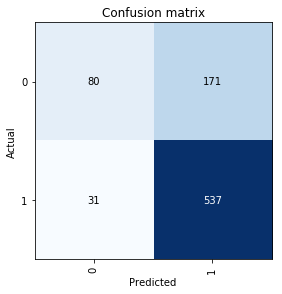

In [40]:
txt_ci = TextClassificationInterpretation.from_learner(learn)
txt_ci.plot_confusion_matrix()

In [42]:
txt_ci.show_top_losses(10)

Text,Prediction,Actual,Loss,Probability
xxbos ipados xxmaj dark xxmaj mode and xxmaj sign in xxmaj with xxmaj apple xxmaj all the xxmaj biggest xxmaj news xxmaj from xxup wwdc,1,1,2.11,0.88
xxbos xxmaj hackers xxmaj can xxmaj now xxmaj bypass xxmaj two xxmaj factor xxmaj authentication xxmaj with a xxmaj new xxmaj kind of xxmaj phishing xxmaj scam,1,1,1.86,0.84
xxbos xxmaj xxunk xxmaj cuts xxmaj ties xxmaj with xxmaj xxunk xxmaj xxunk xxmaj over xxmaj xxunk xxmaj ocasio xxmaj cortez xxmaj video,1,1,1.85,0.84
xxbos xxmaj how to xxmaj pack for a xxmaj business xxmaj trip,1,1,1.77,0.83
xxbos xxmaj here s xxmaj why xxmaj billion on xxmaj star xxmaj wars xxmaj lands xxmaj is a xxmaj good xxmaj deal for xxup dis xxmaj stock,1,0,1.76,0.17
xxbos time xxmaj dover winner xxmaj xxunk xxmaj johnson fastest in final practice,1,0,1.75,0.17
xxbos a first look at the gardens of xxmaj the xxmaj xxunk xxmaj xxunk xxmaj it s not like anything you ve ever seen,1,1,1.71,0.82
xxbos xxmaj pharma xxmaj stock xxmaj roundup xxup asco xxmaj update xxup fda xxmaj nod for xxup lly s xxmaj xxunk for xxmaj cluster xxmaj headache,1,0,1.66,0.19
xxbos xxmaj peter xxmaj johnson to xxmaj exit as xxup mrc s xxmaj head of xxup tv xxmaj development,1,1,1.65,0.81
xxbos xxmaj stocks to xxmaj buy xxmaj as xxmaj they xxmaj hit xxmaj week xxmaj lows,1,0,1.64,0.19
